In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../k6/results/ssrv/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    if 'B' in value:
        return str(int(float(value.replace('B', '')) / 1024))
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, dataset, features, height=3, width=20):
    cols = len(features)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, f in enumerate(features):
        plot_func(dataset, f, axes[x], idx=x)
    return plt

# 5.000 VUs

In [2]:
dirty_df = pd.read_csv(f'{path}5000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,homepage_cpu_percent,monolith_cpu_percent,recommendations_cpu_percent,teasers_cpu_percent,cdn_mem_percent,discovery_mem_percent,homepage_mem_percent,...,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,30,0.00,2.21,50.41,18.93,0.00,0.00,0.32,0.74,2.49,...,8.72,5.70,11.46,417,83.40,83.00,84.00,417.00,0.00,0.00
1,35,0.00,2.05,50.56,9.06,0.00,0.00,0.32,0.74,2.54,...,8.83,5.98,15.43,416,83.40,83.00,84.00,417.00,0.00,0.00
2,40,0.00,4.35,47.76,11.83,0.00,0.00,0.32,0.80,2.54,...,8.79,5.91,13.06,417,83.20,83.00,84.00,416.00,0.00,0.00
3,45,0.00,2.18,53.44,8.95,0.00,0.00,0.32,0.80,2.55,...,8.80,5.83,16.29,417,83.40,83.00,84.00,417.00,0.00,0.00
4,50,0.00,2.09,53.66,8.00,0.00,0.00,0.32,0.80,2.56,...,8.69,5.84,13.26,416,83.40,83.00,84.00,417.00,0.00,0.00
5,55,0.00,2.04,51.31,9.62,0.00,0.00,0.32,0.80,2.55,...,8.77,5.75,14.44,417,83.20,83.00,84.00,416.00,0.00,0.00
6,60,0.00,2.20,45.14,8.58,0.00,0.00,0.32,0.81,2.63,...,8.81,5.91,15.03,417,83.40,83.00,84.00,417.00,0.00,0.00
7,65,0.00,2.11,48.57,7.32,0.00,0.00,0.32,0.81,2.64,...,8.78,5.67,13.99,416,83.40,83.00,84.00,417.00,0.00,0.00
8,70,0.00,2.20,49.09,7.66,0.00,0.00,0.32,0.81,2.63,...,8.81,5.90,13.02,417,83.20,83.00,84.00,416.00,0.00,0.00
9,75,0.00,2.26,50.80,8.18,0.00,0.00,0.32,0.82,2.68,...,8.73,5.96,14.36,417,83.40,83.00,84.00,417.00,0.00,0.00


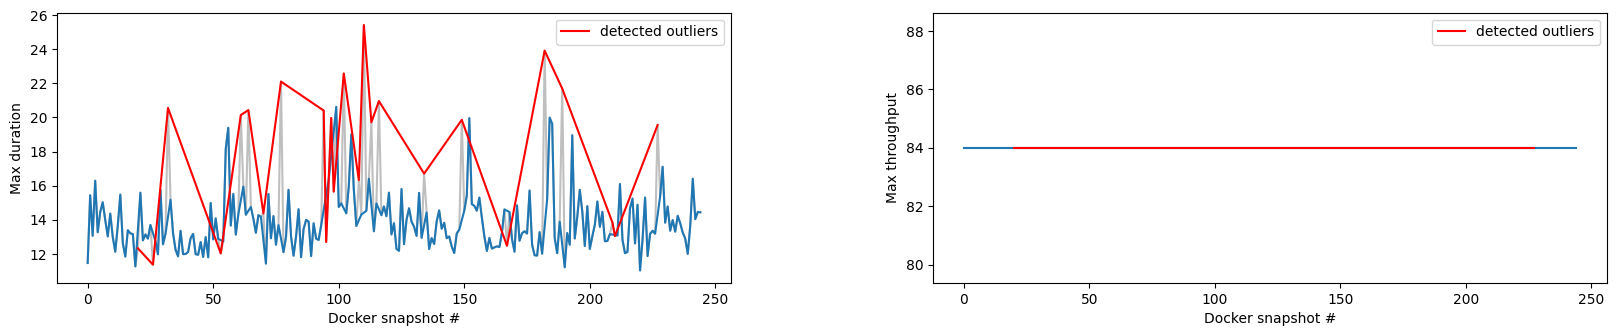

In [3]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

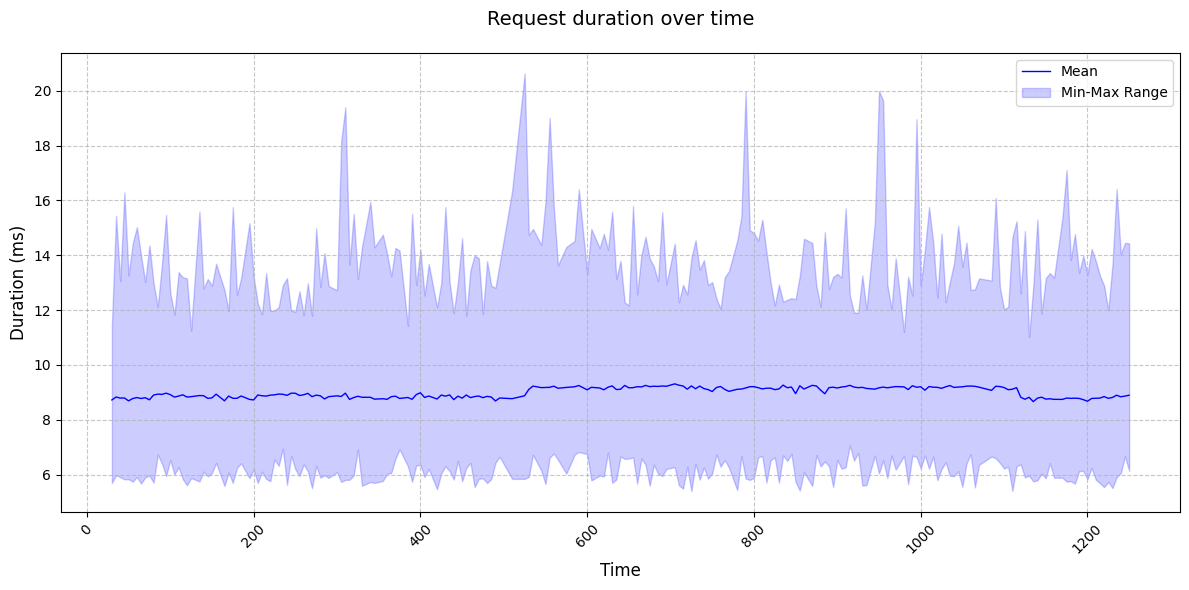

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

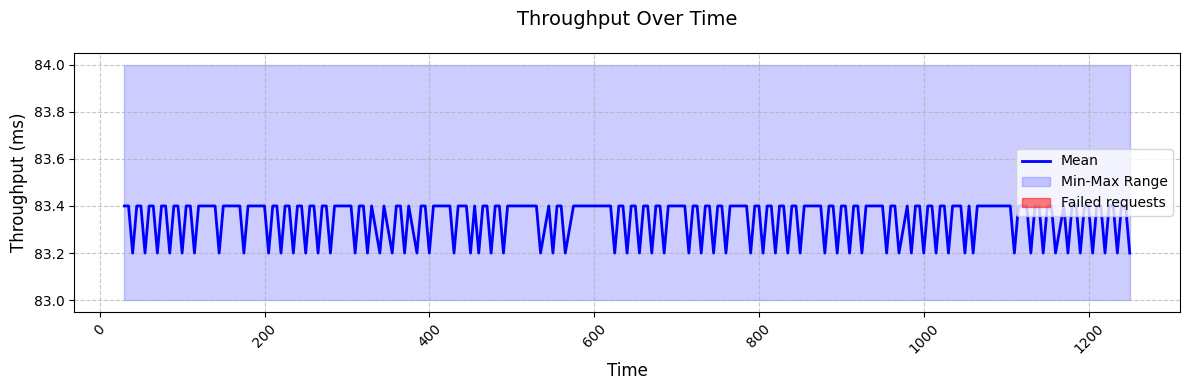

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

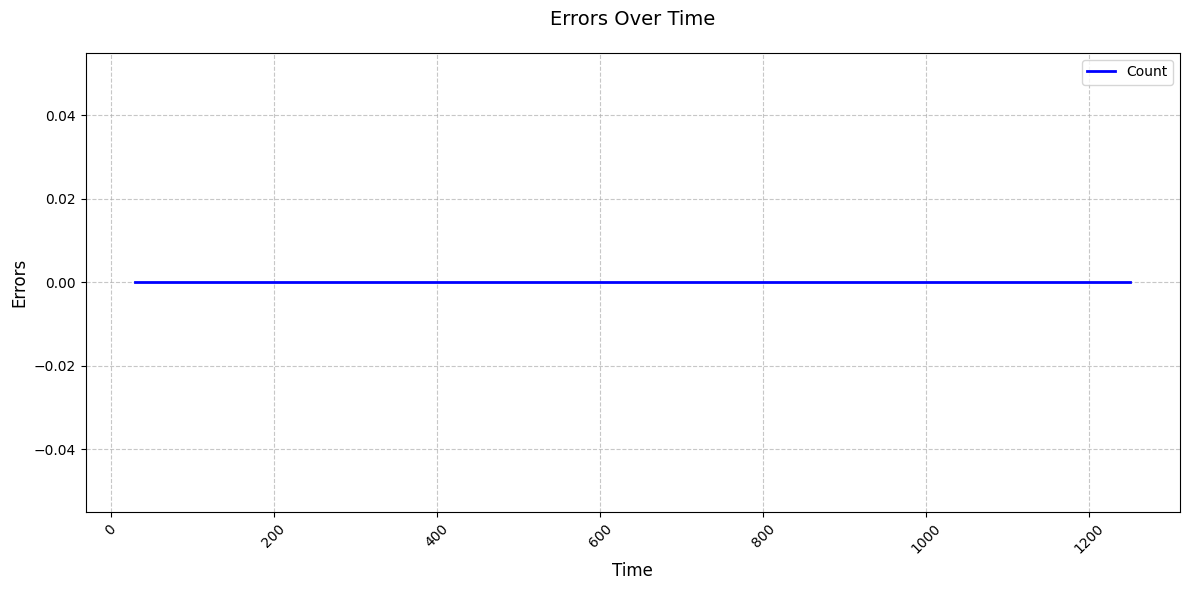

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 10.000 VUs

In [7]:
dirty_df = pd.read_csv(f'{path}10000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,homepage_cpu_percent,monolith_cpu_percent,recommendations_cpu_percent,teasers_cpu_percent,cdn_mem_percent,discovery_mem_percent,homepage_mem_percent,...,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,40,0.00,2.96,78.97,33.34,0.00,0.00,0.32,0.82,2.93,...,7.89,5.69,14.96,833,166.80,166.00,167.00,834.00,0.00,0.00
1,45,0.00,3.61,72.20,14.09,0.00,0.00,0.32,0.82,2.94,...,7.81,5.58,18.46,833,166.60,166.00,167.00,833.00,0.00,0.00
2,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.87,5.42,13.17,833,166.80,166.00,167.00,834.00,0.00,0.00
3,60,0.00,3.87,71.62,12.74,0.00,0.00,0.32,0.60,2.94,...,7.88,5.65,17.67,833,166.60,166.00,167.00,833.00,0.00,0.00
4,65,0.00,3.25,76.71,13.06,0.00,0.00,0.32,0.65,2.95,...,7.78,5.48,13.64,834,166.60,166.00,167.00,833.00,0.00,0.00
5,70,0.00,3.78,71.22,27.77,0.00,0.00,0.32,0.79,2.97,...,7.79,5.58,14.07,833,166.80,166.00,167.00,834.00,0.00,0.00
6,75,0.00,5.01,76.63,79.98,0.00,0.00,0.32,0.83,2.93,...,7.80,5.60,12.29,833,166.60,166.00,167.00,833.00,0.00,0.00
7,80,0.01,3.21,74.97,11.77,0.00,0.00,0.32,0.83,2.95,...,7.73,5.51,12.43,834,166.80,166.00,167.00,834.00,0.00,0.00
8,85,0.00,4.36,75.64,12.36,0.00,0.00,0.32,0.84,3.01,...,7.77,5.47,13.17,833,166.60,166.00,167.00,833.00,0.00,0.00
9,90,0.00,3.07,71.33,12.48,0.00,0.00,0.32,0.84,3.03,...,7.83,5.60,17.31,833,166.60,166.00,167.00,833.00,0.00,0.00


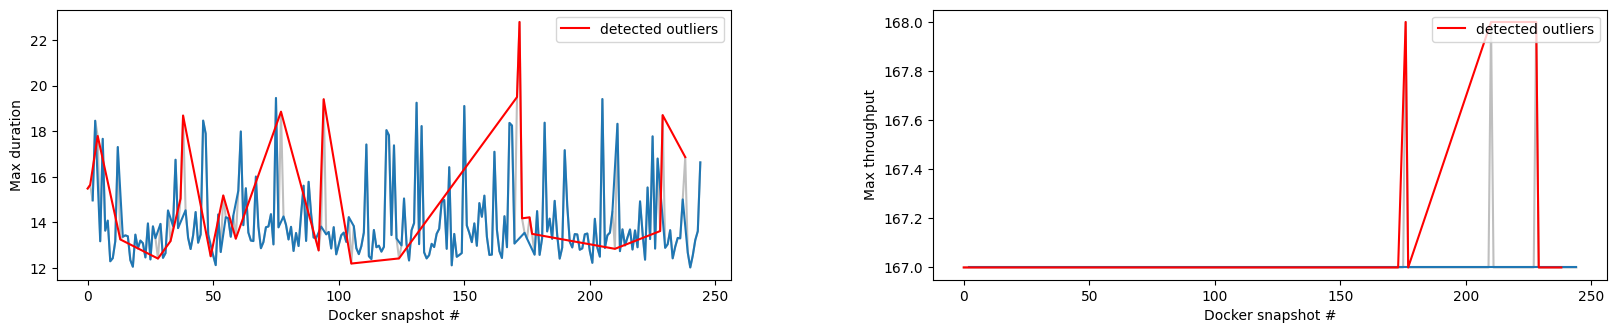

In [8]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

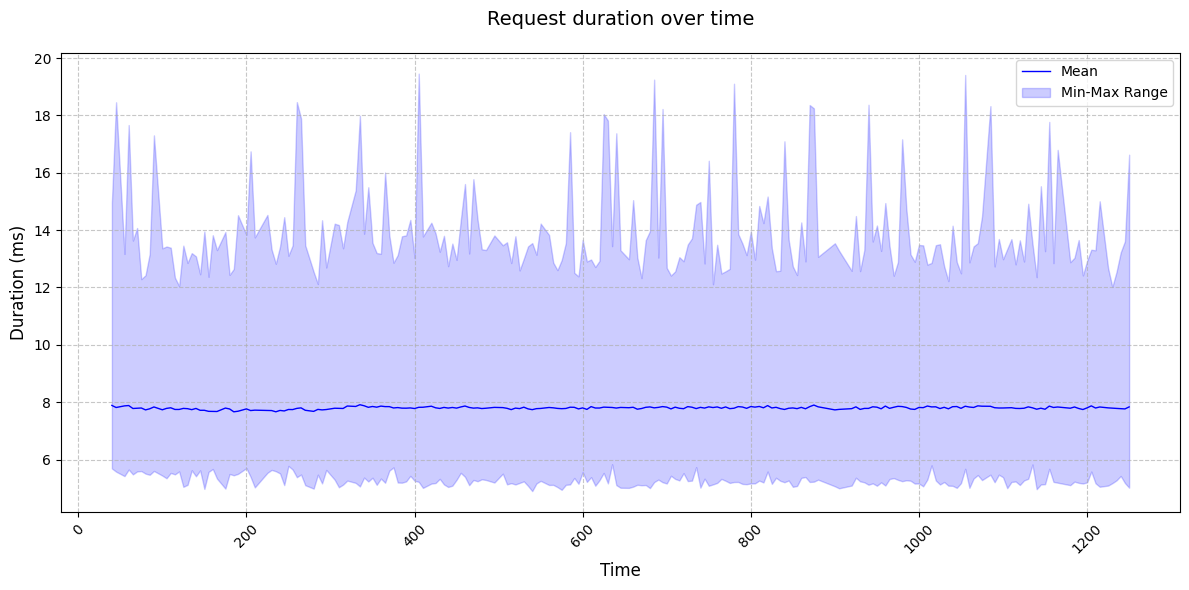

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

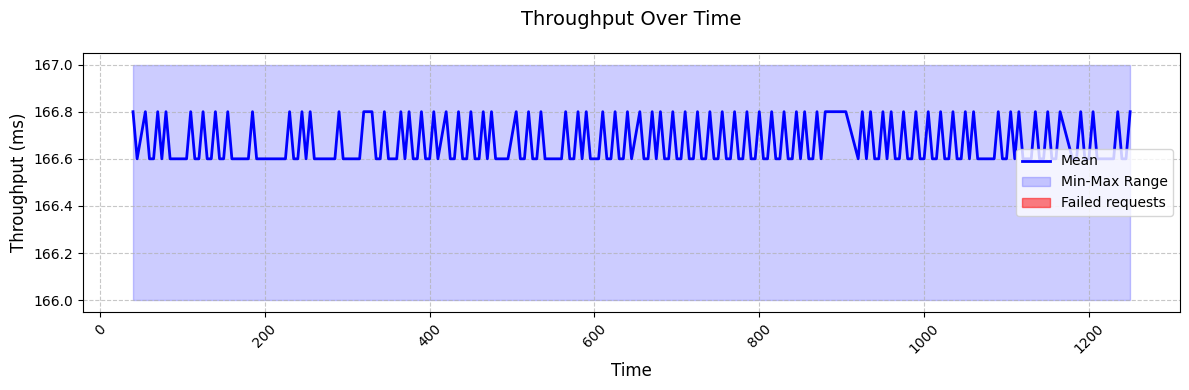

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

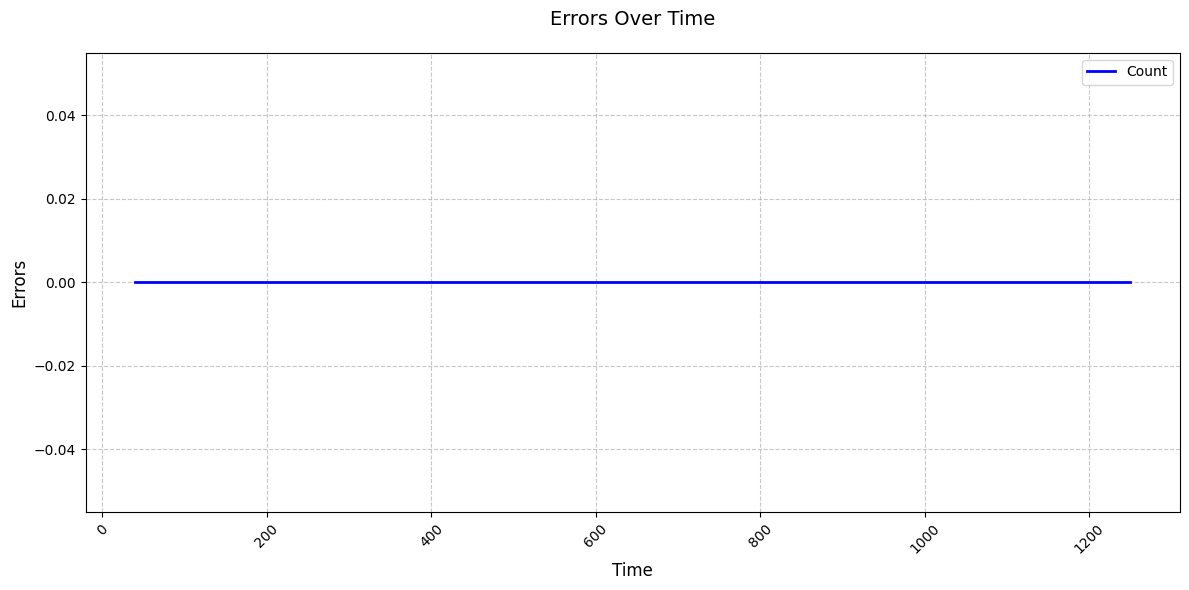

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()